In [4]:
from pvlib import pvsystem, singlediode
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from scipy.constants import e as qe, k as kB



# For simplicity, use cell temperature of 25C for all calculations.
# kB is J/K, qe is C=J/V
# kB * T / qe -> V
Vth = kB * (273.15+25) / qe

cell_parameters = {
    'I_L_ref': 8.24,
    'I_o_ref': 2.36e-9,
    'a_ref': 1.3*Vth,
    'R_sh_ref': 1000,
    'R_s': 0.00181,
    'alpha_sc': 0.0042,
    'breakdown_factor': 2e-3,
    'breakdown_exp': 3,
    'breakdown_voltage': -15,
}

# PVLib example

In [207]:
def calcMPP_IscVocFF(Isys, Vsys):
    """from PVmismatch"""
    Psys = Isys * Vsys
    mpp = np.argmax(Psys)
    if Psys[mpp] == 0:
        Imp, Vmp, Pmp, Isc, Voc, FF = 0, 0, 0, 0, 0, 0
    else:
        P = Psys[mpp - 1:mpp + 2]
        V = Vsys[mpp - 1:mpp + 2]
        I = Isys[mpp - 1:mpp + 2]

        if any(P) == 0 or any(V) == 0 or any(I) == 0:
            Imp, Vmp, Pmp, Isc, Voc, FF = 0, 0, 0, 0, 0, 0
        else:
            # calculate derivative dP/dV using central difference
            dP = np.diff(P, axis=0)  # size is (2, 1)
            dV = np.diff(V, axis=0)  # size is (2, 1)
            if any(dP) == 0 or any(dV) == 0:
                Imp, Vmp, Pmp, Isc, Voc, FF = 0, 0, 0, 0, 0, 0
            else:
                # Pv = dP / dV  # size is (2, 1)
                Pv = np.divide(dP, dV, out=np.zeros_like(dP), where=dV!=0)
                # dP/dV is central difference at midpoints,
                Vmid = (V[1:] + V[:-1]) / 2.0  # size is (2, 1)
                Imid = (I[1:] + I[:-1]) / 2.0  # size is (2, 1)
                # interpolate to find Vmp

                Vmp = (-Pv[0] * np.diff(Vmid, axis=0) / np.diff(Pv, axis=0) + Vmid[0]).item()
                Imp = (-Pv[0] * np.diff(Imid, axis=0) / np.diff(Pv, axis=0) + Imid[0]).item()
                # calculate max power at Pv = 0
                Pmp = Imp * Vmp
                # calculate Voc, current must be increasing so flipup()
                # Voc = np.interp(np.float64(0), np.flipud(Isys),
                #                 np.flipud(Vsys))
                # Isc = np.interp(np.float64(0), Vsys, Isys)  # calculate Isc
                # FF = Pmp / Isc / Voc

    return dict(zip(['imp', 'vmp', 'pmp'], [Imp, Vmp, Pmp]))

def simulate_full_curve(parameters, Geff, Tcell, ivcurve_pnts=1000):
    """
    Use De Soto and Bishop to simulate a full IV curve with both
    forward and reverse bias regions.
    """
    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    sde_args = pvsystem.calcparams_desoto(
        Geff,
        Tcell,
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
    )
    # sde_args has values:
    # (photocurrent, saturation_current, resistance_series,
    # resistance_shunt, nNsVth)

    # Use Bishop's method to calculate points on the IV curve with V ranging
    # from the reverse breakdown voltage to open circuit
    kwargs = {
        'breakdown_factor': parameters['breakdown_factor'],
        'breakdown_exp': parameters['breakdown_exp'],
        'breakdown_voltage': parameters['breakdown_voltage'],
    }
    v_oc = singlediode.bishop88_v_from_i(
        0.0, *sde_args, **kwargs
    )
    # ideally would use some intelligent log-spacing to concentrate points
    # around the forward- and reverse-bias knees, but this is good enough:
    vd = np.linspace(0.99*kwargs['breakdown_voltage'], v_oc, ivcurve_pnts)

    ivcurve_i, ivcurve_v, _ = singlediode.bishop88(vd, *sde_args, **kwargs)
    return pd.DataFrame({
        'i': ivcurve_i,
        'v': ivcurve_v,
    })
    
def plot_curves(dfs, labels, title, legend=True):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    for df, label in zip(dfs, labels):
        df.plot('v', 'i', label=label, ax=axes[0])
        df.plot('v', 'i', label=label, ax=axes[1])
        axes[0].set_xlim(right=0)
        axes[0].set_ylim([0, 25])
        axes[1].set_xlim([0, df['v'].max()*1.5])
    axes[0].set_ylabel('current [A]')
    axes[0].set_xlabel('voltage [V]')
    axes[1].set_xlabel('voltage [V]')
    if legend==False:
        for ax in axes:
            ax.get_legend().remove()
    fig.suptitle(title)
    fig.tight_layout()
    return axes


def plot_curves_mpp(dfs, labels, title, yadjust, legend=True):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    for df, label, yadjust in zip(dfs, labels, yadjust):
        mpp_dict = calcMPP_IscVocFF(df['i'].values, df['v'].values)
        df.plot('v', 'i', label=label, ax=axes[0])
        df.plot('v', 'i', label=label, ax=axes[1])
        axes[0].set_xlim(right=0)
        axes[0].set_ylim([0, 25])
        axes[1].set_xlim([0, df['v'].max()*1.5])
        axes[1].scatter(mpp_dict['vmp'], mpp_dict['imp'])
        axes[1].text(mpp_dict['vmp'], mpp_dict['imp']+yadjust, f"{label} MPP:\n{round(mpp_dict['pmp'],1)}W")
        
    axes[0].set_ylabel('current [A]')
    axes[0].set_xlabel('voltage [V]')
    axes[1].set_xlabel('voltage [V]')
    if legend==False:
        for ax in axes:
            ax.get_legend().remove()
    elif legend=="right":
        axes[0].get_legend().remove()
        
    fig.suptitle(title)
    fig.tight_layout()
    return axes

cell_curve_full_sun = simulate_full_curve(cell_parameters, Geff=1000, Tcell=25)
cell_curve_shaded = simulate_full_curve(cell_parameters, Geff=200, Tcell=25)
ax = plot_curves_mpp([cell_curve_full_sun, cell_curve_shaded],
                 labels=['Full Sun', 'Shaded'],
                 title='Cell-level reverse- and forward-biased IV curves')

TypeError: plot_curves_mpp() missing 1 required positional argument: 'yadjust'

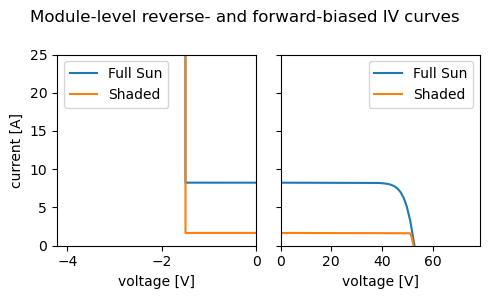

In [119]:
def interpolate(df, i):
    """convenience wrapper around scipy.interpolate.interp1d"""
    f_interp = interp1d(np.flipud(df['i']), np.flipud(df['v']), kind='linear',
                        fill_value='extrapolate')
    return f_interp(i)


def combine_series(dfs):
    """
    Combine IV curves in series by aligning currents and summing voltages.
    The current range is based on the first curve's current range.
    """
    df1 = dfs[0]
    imin = df1['i'].min()
    imax = df1['i'].max()
    i = np.linspace(imin, imax, 1000)
    v = 0
    for df2 in dfs:
        v_cell = interpolate(df2, i)
        v += v_cell
    return pd.DataFrame({'i': i, 'v': v})


def simulate_module(cell_parameters, poa_direct, poa_diffuse, Tcell,
                    shaded_fraction, cells_per_string=24, strings=3):
    """
    Simulate the IV curve for a partially shaded module.
    The shade is assumed to be coming up from the bottom of the module when in
    portrait orientation, so it affects all substrings equally.
    For simplicity, cell temperature is assumed to be uniform across the
    module, regardless of variation in cell-level illumination.
    Substrings are assumed to be "down and back", so the number of cells per
    string is divided between two columns of cells.
    """
    # find the number of cells per column that are in full shadow
    nrow = cells_per_string // 2
    nrow_full_shade = int(shaded_fraction * nrow)
    # find the fraction of shade in the border row
    partial_shade_fraction = 1 - (shaded_fraction * nrow - nrow_full_shade)

    df_lit = simulate_full_curve(
        cell_parameters,
        poa_diffuse + poa_direct,
        Tcell)
    df_partial = simulate_full_curve(
        cell_parameters,
        poa_diffuse + partial_shade_fraction * poa_direct,
        Tcell)
    df_shaded = simulate_full_curve(
        cell_parameters,
        poa_diffuse,
        Tcell)
    # build a list of IV curves for a single column of cells (half a substring)
    include_partial_cell = (shaded_fraction < 1)
    half_substring_curves = (
        [df_lit] * (nrow - nrow_full_shade - 1)
        + ([df_partial] if include_partial_cell else [])  # noqa: W503
        + [df_shaded] * nrow_full_shade  # noqa: W503
    )
    substring_curve = combine_series(half_substring_curves)
    substring_curve['v'] *= 2  # turn half strings into whole strings
    # bypass diode:
    substring_curve['v'] = substring_curve['v'].clip(lower=-0.5)
    # no need to interpolate since we're just scaling voltage directly:
    substring_curve['v'] *= strings
    return substring_curve

kwargs = {
    'cell_parameters': cell_parameters,
    'poa_direct': 800,
    'poa_diffuse': 200,
    'Tcell': 25
}
module_curve_full_sun = simulate_module(shaded_fraction=0, **kwargs)
module_curve_shaded = simulate_module(shaded_fraction=0.1, **kwargs)
ax = plot_curves([module_curve_full_sun, module_curve_shaded],
                 labels=['Full Sun', 'Shaded'],
                 title='Module-level reverse- and forward-biased IV curves')

# My Test

In [160]:
# set up module
module_irrad = np.array(
    [
        [800, 800, 800, 800, 800, 800],
        [800, 800, 800, 800, 800, 800],
        [800, 800, 800, 800, 800, 800],
        [800, 800, 800, 800, 800, 800],
        [300, 800, 800, 800, 800, 800],
        [290, 285, 800, 800, 800, 800],
        [275, 280, 800, 800, 800, 800],
        [250, 260, 800, 800, 800, 800],
    ]
)

module_bypass = np.array(
    [
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
    ]
)

aa = np.arange(0,ncols)
bb = np.arange(0,nrows)

a, b = np.meshgrid(aa,bb)
module_idx = np.zeros(a.shape, dtype='int,int')

module_idx['f0']=b
module_idx['f1']=a
# arr = arr.flatten()




## NOCT Full Module

array([<AxesSubplot:xlabel='voltage [V]', ylabel='current [A]'>,
       <AxesSubplot:xlabel='voltage [V]'>], dtype=object)

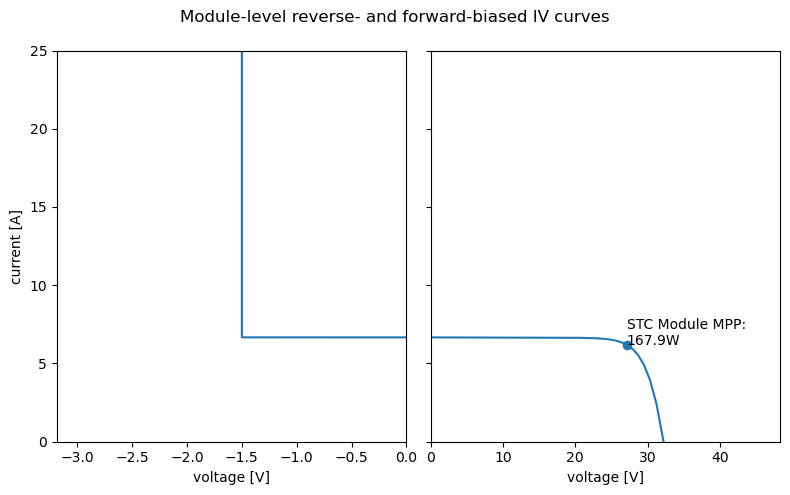

In [199]:
noct_module_irrad = (module_irrad * 0) + 800
t_air = 20
NOCT = 42.5

module_iv = {}

for n,idx in enumerate(module_idx.flatten()):
        row = idx[0]
        col = idx[1]
        

        Gcell = noct_module_irrad[row,col]
        Tcell = t_air + (((NOCT - 20) / 80) * (Gcell/10)) # standard NOCT temperature equation

        res = simulate_full_curve(
                cell_parameters,
                Gcell,
                Tcell)
        module_iv[f"{row},{col}"] = res
        
submodule_curves = []
for diode in [0,1,2]:
    submodule_idx = module_idx[module_bypass==diode]
    submodule_curve = combine_series([module_iv[f"{row},{col}"] for row,col in submodule_idx])
    submodule_curves.append(submodule_curve.clip(lower=-0.5))
    

module_iv_curve = combine_series(submodule_curves)
mpp_dict = calcMPP_IscVocFF(module_iv_curve["i"].values, module_iv_curve['v'].values)

plot_curves_mpp([module_iv_curve],
                labels=["STC Module"],
                title='Module-level reverse- and forward-biased IV curves',legend=False)

## NOCT Each Subtring

array([<AxesSubplot:xlabel='voltage [V]', ylabel='current [A]'>,
       <AxesSubplot:xlabel='voltage [V]'>], dtype=object)

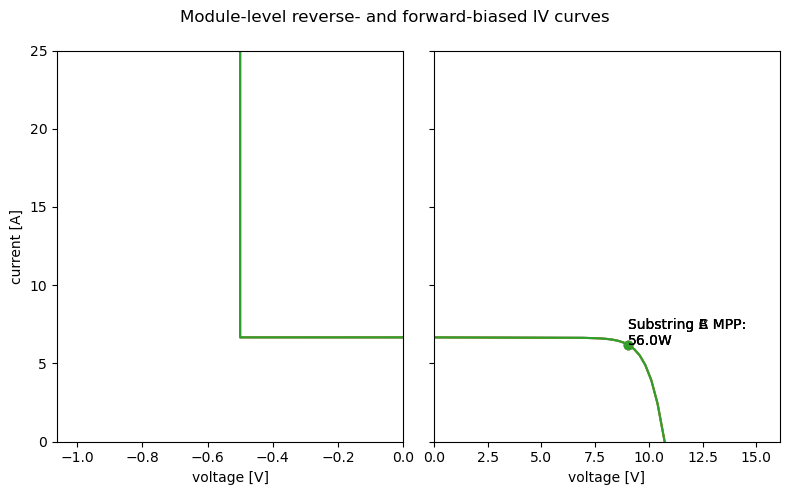

In [200]:
noct_module_irrad = (module_irrad * 0) + 800
t_air = 20
NOCT = 42.5

module_iv = {}

for n,idx in enumerate(module_idx.flatten()):
        row = idx[0]
        col = idx[1]
        

        Gcell = noct_module_irrad[row,col]
        Tcell = t_air + (((NOCT - 20) / 80) * (Gcell/10)) # standard NOCT temperature equation

        res = simulate_full_curve(
                cell_parameters,
                Gcell,
                Tcell)
        module_iv[f"{row},{col}"] = res
        
submodule_curves = []
for diode in [0,1,2]:
    submodule_idx = module_idx[module_bypass==diode]
    submodule_curve = combine_series([module_iv[f"{row},{col}"] for row,col in submodule_idx])
    submodule_curves.append(submodule_curve.clip(lower=-0.5))
    

module_iv_curve = combine_series(submodule_curves)

plot_curves_mpp(submodule_curves,
                labels=["Substring A","Substring B","Substring C"],
                title='Module-level reverse- and forward-biased IV curves',legend=False)

## Partial Shading

In [202]:
t_air = 20
NOCT = 42.5

module_iv = {}

for n,idx in enumerate(module_idx.flatten()):
        row = idx[0]
        col = idx[1]
        

        Gcell = module_irrad[row,col]
        Tcell = t_air + (((NOCT - 20) / 80) * (Gcell/10)) # standard NOCT temperature equation

        res = simulate_full_curve(
                cell_parameters,
                Gcell,
                Tcell)
        module_iv[f"{row},{col}"] = res

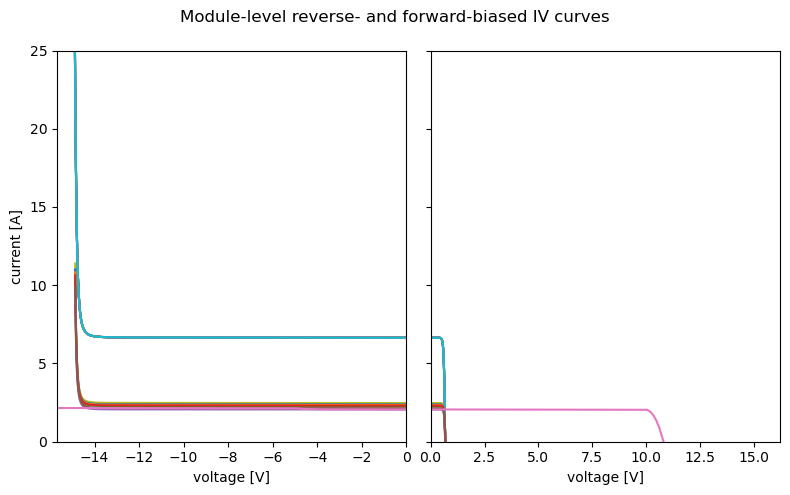

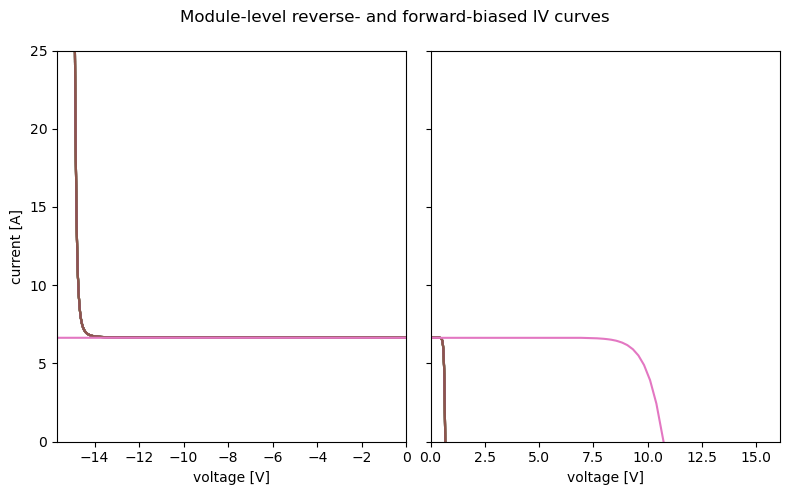

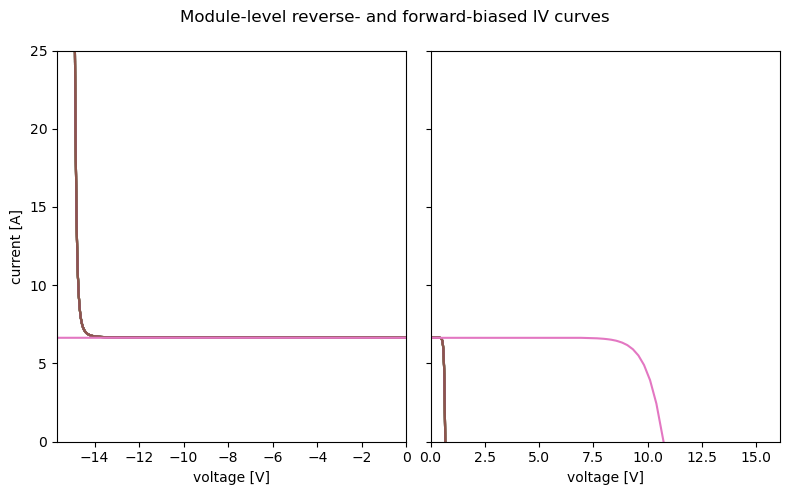

In [203]:
submodule_curves = []
for diode in [0,1,2]:
    submodule_idx = module_idx[module_bypass==diode]
    submodule_curve = combine_series([module_iv[f"{row},{col}"] for row,col in submodule_idx])
    submodule_curves.append(submodule_curve.clip(lower=-0.5))
    plot_curves([module_iv[f"{row},{col}"] for row,col in submodule_idx]+[submodule_curve],
                    labels=[f"{row},{col}" for row,col in submodule_idx]+["series"],
                    title='Module-level reverse- and forward-biased IV curves',legend=False)

array([<AxesSubplot:xlabel='voltage [V]', ylabel='current [A]'>,
       <AxesSubplot:xlabel='voltage [V]'>], dtype=object)

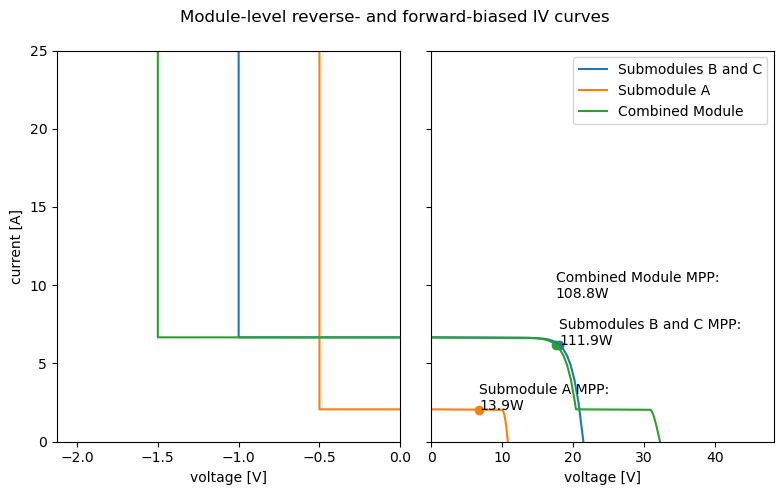

In [211]:

plot_curves_mpp([combine_series(submodule_curves[1:]),
             combine_series(submodule_curves[0:1]),
             combine_series(submodule_curves)],
                    labels=["Submodules B and C","Submodule A", "Combined Module"],
                    title='Module-level reverse- and forward-biased IV curves',
                    yadjust=[0,0,3],
                    legend="right")

In [155]:
print(max(combine_series(submodule_curves[1:])["i"] * combine_series(submodule_curves[1:])["v"]))
print(max(combine_series(submodule_curves[0:1])["i"] * combine_series(submodule_curves[0:1])["v"]))
print(max(combine_series(submodule_curves)["i"] * combine_series(submodule_curves)["v"]))

108.76597567383355
20.036205413982756
105.67330113503444
